In [58]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


In [96]:
ticker = "AAPL"
start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data['Close']
log_returns= np.log(close_prices / close_prices.shift(1))
mean_estimate = log_returns.mean()
variance_estimate = log_returns.var()
print("Overall Mean Estimate (log returns):", mean_estimate)
print("Overall Realized Variance Estimate (log returns):", variance_estimate)
data

[*********************100%***********************]  1 of 1 completed

Overall Mean Estimate (log returns): Ticker
AAPL    0.000892
dtype: float64
Overall Realized Variance Estimate (log returns): Ticker
AAPL    0.000319
dtype: float64


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440329,6.455075,6.391277,6.422875,493729600
2010-01-05,6.451466,6.487879,6.417459,6.458086,601904800
2010-01-06,6.348846,6.477045,6.342226,6.451466,552160000
2010-01-07,6.337108,6.379841,6.291065,6.372318,477131200
2010-01-08,6.379241,6.379844,6.291369,6.328684,447610800
...,...,...,...,...,...
2025-04-07,181.460007,194.149994,174.619995,177.199997,160466300
2025-04-08,172.419998,190.339996,169.210007,186.699997,120859500


In [60]:
window_size = 252

# Compute rolling mean and rolling variance of the log returns
rolling_mean = log_returns.rolling(window=window_size).mean()
rolling_variance = log_returns.rolling(window=window_size).var()

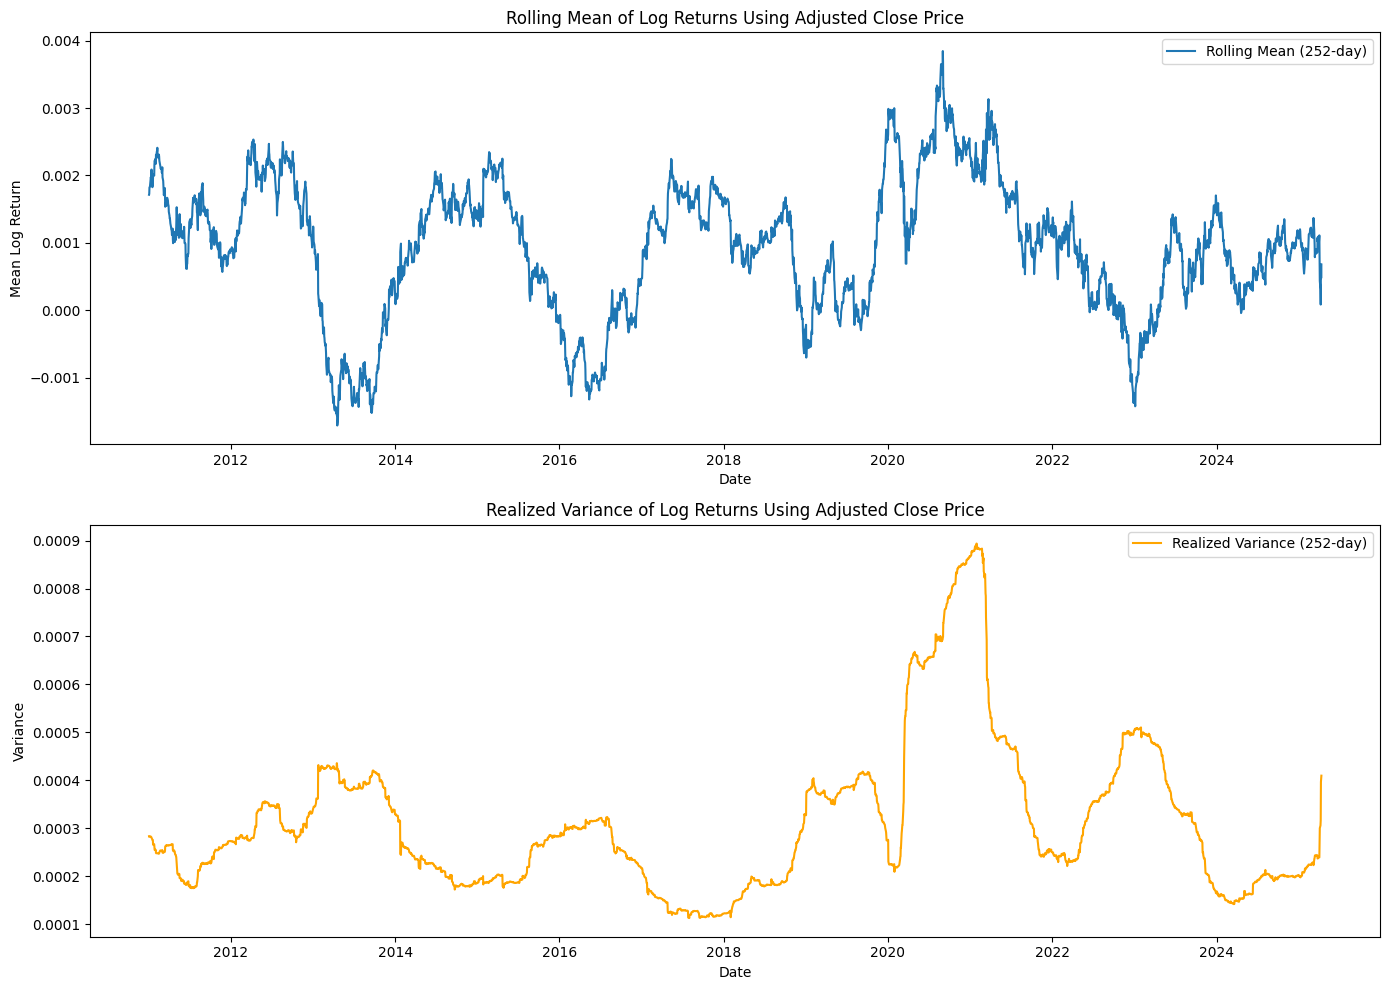

In [61]:
# Plot the rolling estimators
plt.figure(figsize=(14, 10))

# Plot rolling mean
plt.subplot(2, 1, 1)
plt.plot(rolling_mean, label="Rolling Mean (252-day)")
plt.title("Rolling Mean of Log Returns Using Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Mean Log Return")
plt.legend()

# Plot realized variance (rolling variance)
plt.subplot(2, 1, 2)
plt.plot(rolling_variance, label="Realized Variance (252-day)", color='orange')
plt.title("Realized Variance of Log Returns Using Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
def historical_mean_strict(close):
    n = len(close)
    delta_t = 1
    mu = 0
    for i in range(n - 1):
        mu += (1 / delta_t) * (close[i + 1] - close[i]) / close[i]
    mu = mu / n
    return mu

In [63]:
def historical_var_strict(close):
    n = len(close)
    delta_t = 1
    sigma = 0
    for j in range(n - 1):
        sigma += (1 / delta_t) * ((close[j + 1] - close[j]) / close[j])**2
    mu = historical_mean_strict(close)
    sigma = (1 / (n - 1)) * sigma - (n / (n - 1)) * mu**2
    sigma = np.sqrt(sigma)
    return sigma


In [64]:
# Calculate the historical mean and variance using strict method
historical_mean = historical_mean_strict(close_prices.values)  
historical_variance = historical_var_strict(close_prices.values)
print("Historical Mean (strict method):", historical_mean)
print("Historical Variance (strict method):", historical_variance)

Historical Mean (strict method): [0.0010516]
Historical Variance (strict method): [0.01787103]


In [65]:
def parkinson_volatility_estimator(data):
    """
    Calculate the Parkinson volatility estimator for the given close prices.
    """
    log_ranges = np.log(data["High"] / data["Low"]) ** 2
    sum_log_ranges = log_ranges.sum()
    parkinson_daily = math.sqrt((1.0 / (4.0 * len(data) * math.log(2))) * sum_log_ranges)
    return parkinson_daily
# Calculate the Parkinson volatility estimator
parkinson_volatility = parkinson_volatility_estimator(data)
print("Parkinson Volatility Estimator:", parkinson_volatility)  


Parkinson Volatility Estimator: 0.014156252387226852


/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_24617/4089986607.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  parkinson_daily = math.sqrt((1.0 / (4.0 * len(data) * math.log(2))) * sum_log_ranges)


In [92]:
def parkinson_vol_from_array(x):
    high = x[ :, 0]
    low = x[:, 1]
    
    squared_log_range = np.log(high / low) ** 2
    return math.sqrt((1.0 / (4.0 * len(x) * math.log(2))) * squared_log_range.mean())

In [106]:
data_subset = data[ ['High', 'Low']]
data_subset
data_P = data_subset.rolling(window=30).apply(parkinson_vol_from_array, raw=False)

KeyError: 'key of type tuple not found and not a MultiIndex'

/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_24617/2150015593.py:6: RuntimeWarning: Mean of empty slice.
  return math.sqrt((1.0 / (4.0 * len(x) * math.log(2))) * squared_log_range.mean())
/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_24617/678642260.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu += (1 / delta_t) * (close[i + 1] - close[i]) / close[i]


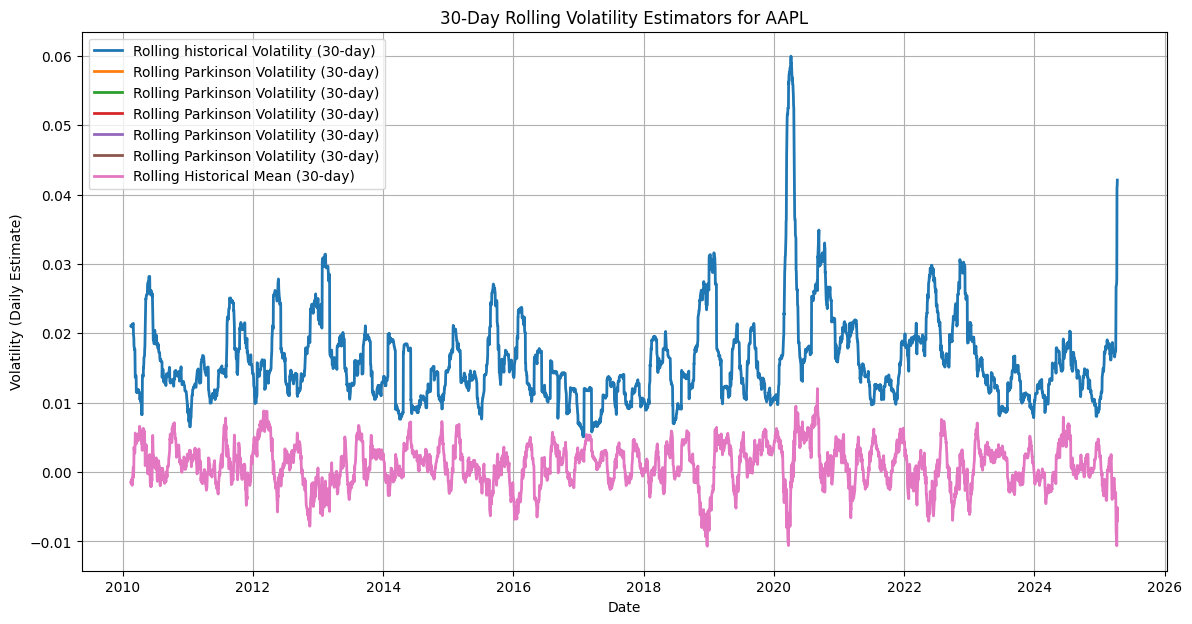

In [91]:
window_size = 30
# Calculate the Parkinson volatility estimator for rolling windows
rolling_parkinson_volatility = data.rolling(window=window_size).apply(parkinson_vol_from_array, raw=True)
#Calculate the rolling historical mean and variance
rolling_historical_mean = close_prices.rolling(window=window_size).apply(historical_mean_strict, raw=False) 
rolling_historical_variance = close_prices.rolling(window=window_size).apply(historical_var_strict, raw=False)
plt.figure(figsize=(14, 7))
plt.plot(rolling_historical_variance, label='Rolling historical Volatility (30-day)', lw=2)
plt.plot(rolling_parkinson_volatility, label='Rolling Parkinson Volatility (30-day)', lw=2)
plt.plot(rolling_historical_mean, label='Rolling Historical Mean (30-day)', lw=2)
plt.title(f'30-Day Rolling Volatility Estimators for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volatility (Daily Estimate)')
plt.legend()
plt.grid(True)
plt.show()
